In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
from scipy import sparse 
import itertools

import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu


In [2]:
outdir     = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results"
outfigdir  = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807"

In [3]:
adata_raw = anndata.read("../../data/cheng21_cell_scrna/reorganized/all_IT.h5ad")
adata_raw = adata_raw[adata_raw.obs['Subclass'].isin(['L5IT', 'L6IT'])]
adata_raw = adata_raw[adata_raw.obs['cond'].isin(['P28NR'])] # , 'P28DR'])]
counts = adata_raw.X
allgenes = adata_raw.var.index.values
adata_raw

View of AnnData object with n_obs × n_vars = 2285 × 53801
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond'

In [4]:
# get updated cell types
f = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/allL23_newtypes.csv"
meta = pd.read_csv(f, index_col=0)
meta

/tmp/ipykernel_13717/12491127.py:3: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(f, index_col=0)


,Class_broad,Doublet,Doublet Score,batch,leiden,n_counts,n_genes,percent_mito,sample,Type,Subclass,cond,easitype,umap1,umap2,easisample,easicond,newtype
AAACGCTCACTTCATT-1-P8_1a-P8,Excitatory,False,0.025713,1,0,23384.0,4943,0.000128,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGGATAGGTGCATG-1-P8_1a-P8,Excitatory,False,0.011883,1,0,17774.0,4698,0.000169,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGGGCCAGTATACC-1-P8_1a-P8,Excitatory,False,0.024667,1,0,15872.0,4173,0.000126,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGTCCCATATACCG-1-P8_1a-P8,Excitatory,False,0.027921,1,0,20076.0,4761,0.000050,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGTCCTCAGATGCT-1-P8_1a-P8,Excitatory,False,0.009527,1,4,19061.0,4601,0.000000,P8_1a,L2/3_BC,L2/3,P8NR,L2/3_C,NaN,NaN,1a,1-P08NR,L2/3_C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCAGTTGTTG-1-P38_dr_1a,NaN,False,0.042872,11,1,11379.0,3568,0.000879,P38_dr_1a,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,1a,2-P38DR,L2/3_B
TTTGGTTTCTGCCTGT-1-P38_dr_2b,NaN,False,0.007108,2,1,16050.0,3104,0.000062,P38_dr_2b,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,2b,2-P38DR,L2/3_B
TTTGTTGCACCGGTCA-1-P38_dr_2a,NaN,False,0.030928,2,1,13955.0,3739,0.001146,P38_dr_2a,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,2a,2-P38DR,L2/3_B
TTTGTTGGTGGCTAGA-1-P38_dr_2b,NaN,False,0.015884,3,4,7272.0,2789,0.000963,P38_dr_2b,L2/3_2,L2/3,P38DR,L2/3_B,NaN,NaN,2b,2-P38DR,L2/3_A


In [5]:
# update new type 
adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()
adata_raw.obs.update(meta[['newtype']])

/tmp/ipykernel_13717/3478751590.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()


In [6]:
conds = adata_raw.obs['cond'].values
types = adata_raw.obs['Type'].values
newtypes = adata_raw.obs['newtype'].values
samps = adata_raw.obs['sample'].values

rename_dict = {
    "L2/3_A": "L2/3_A",
    "L2/3_B": "L2/3_B",
    "L2/3_C": "L2/3_C",
    
    "L2/3_1": "L2/3_A",
    "L2/3_2": "L2/3_B",
    "L2/3_3": "L2/3_C",
    
    "L2/3_AB": "L2/3_A",
    "L2/3_BC": "L2/3_C",
}

def rename(x):
    """
    """
    if x in rename_dict.keys():
        return rename_dict[x]
    else:
        return x
    
adata_raw.obs['easitype'] = adata_raw.obs['Type'].apply(rename)

In [7]:
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/P28NR_ITgrad_genes_n749_n338unq_230420.csv'
df2 = pd.read_csv(f)
genes_it = df2['gene'].unique()
# genes_it

In [8]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_l23 = df['gene'].values
# genes_sel = adata_raw.var.index.values
# genes_grp = df['P17on'].astype(str).values
# assert len(genes_sel) == len(np.unique(genes_sel))

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
gptidx = np.argsort(gpt)

In [9]:
genes_it.shape, genes_l23.shape, np.intersect1d(genes_it, genes_l23).shape

((338,), (286,), (89,))

In [10]:
# filter genes
cond = np.ravel((adata_raw.X>0).sum(axis=0)) > 10 # expressed in more than 10 cells
adata_sub = adata_raw[:,cond]

# counts
x = adata_sub.X
cov = adata_sub.obs['n_counts'].values
genes = adata_sub.var.index.values

# CP10k
xn = (sparse.diags(1/cov).dot(x))*1e4

# log10(CP10k+1)
xln = xn.copy()
xln.data = np.log10(xln.data+1)

adata_sub.layers['norm'] = xn
adata_sub.layers['lognorm'] = xln

In [11]:
adata_sub.shape

(2285, 17363)

In [12]:
# select HVGs with mean and var
nbin = 20
qth = 0.3

# min
gm = np.ravel(xn.mean(axis=0))

# var
tmp = xn.copy()
tmp.data = np.power(tmp.data, 2)
gv = np.ravel(tmp.mean(axis=0))-gm**2

# cut 
lbl = pd.qcut(gm, nbin, labels=np.arange(nbin))
gres = pd.DataFrame()
gres['name'] = genes
gres['lbl'] = lbl
gres['mean'] = gm
gres['var'] = gv
gres['ratio']= gv/gm

# select
gres_sel = gres.groupby('lbl')['ratio'].nlargest(int(qth*(len(gm)/nbin))) #.reset_index()
gsel_idx = np.sort(gres_sel.index.get_level_values(1).values)

assert np.all(gsel_idx != -1)

In [13]:
l23_gidx = basicu.get_index_from_array(genes, genes_l23)
assert np.all(l23_gidx != -1)

it_gidx = basicu.get_index_from_array(genes, genes_it)
assert np.all(it_gidx != -1)

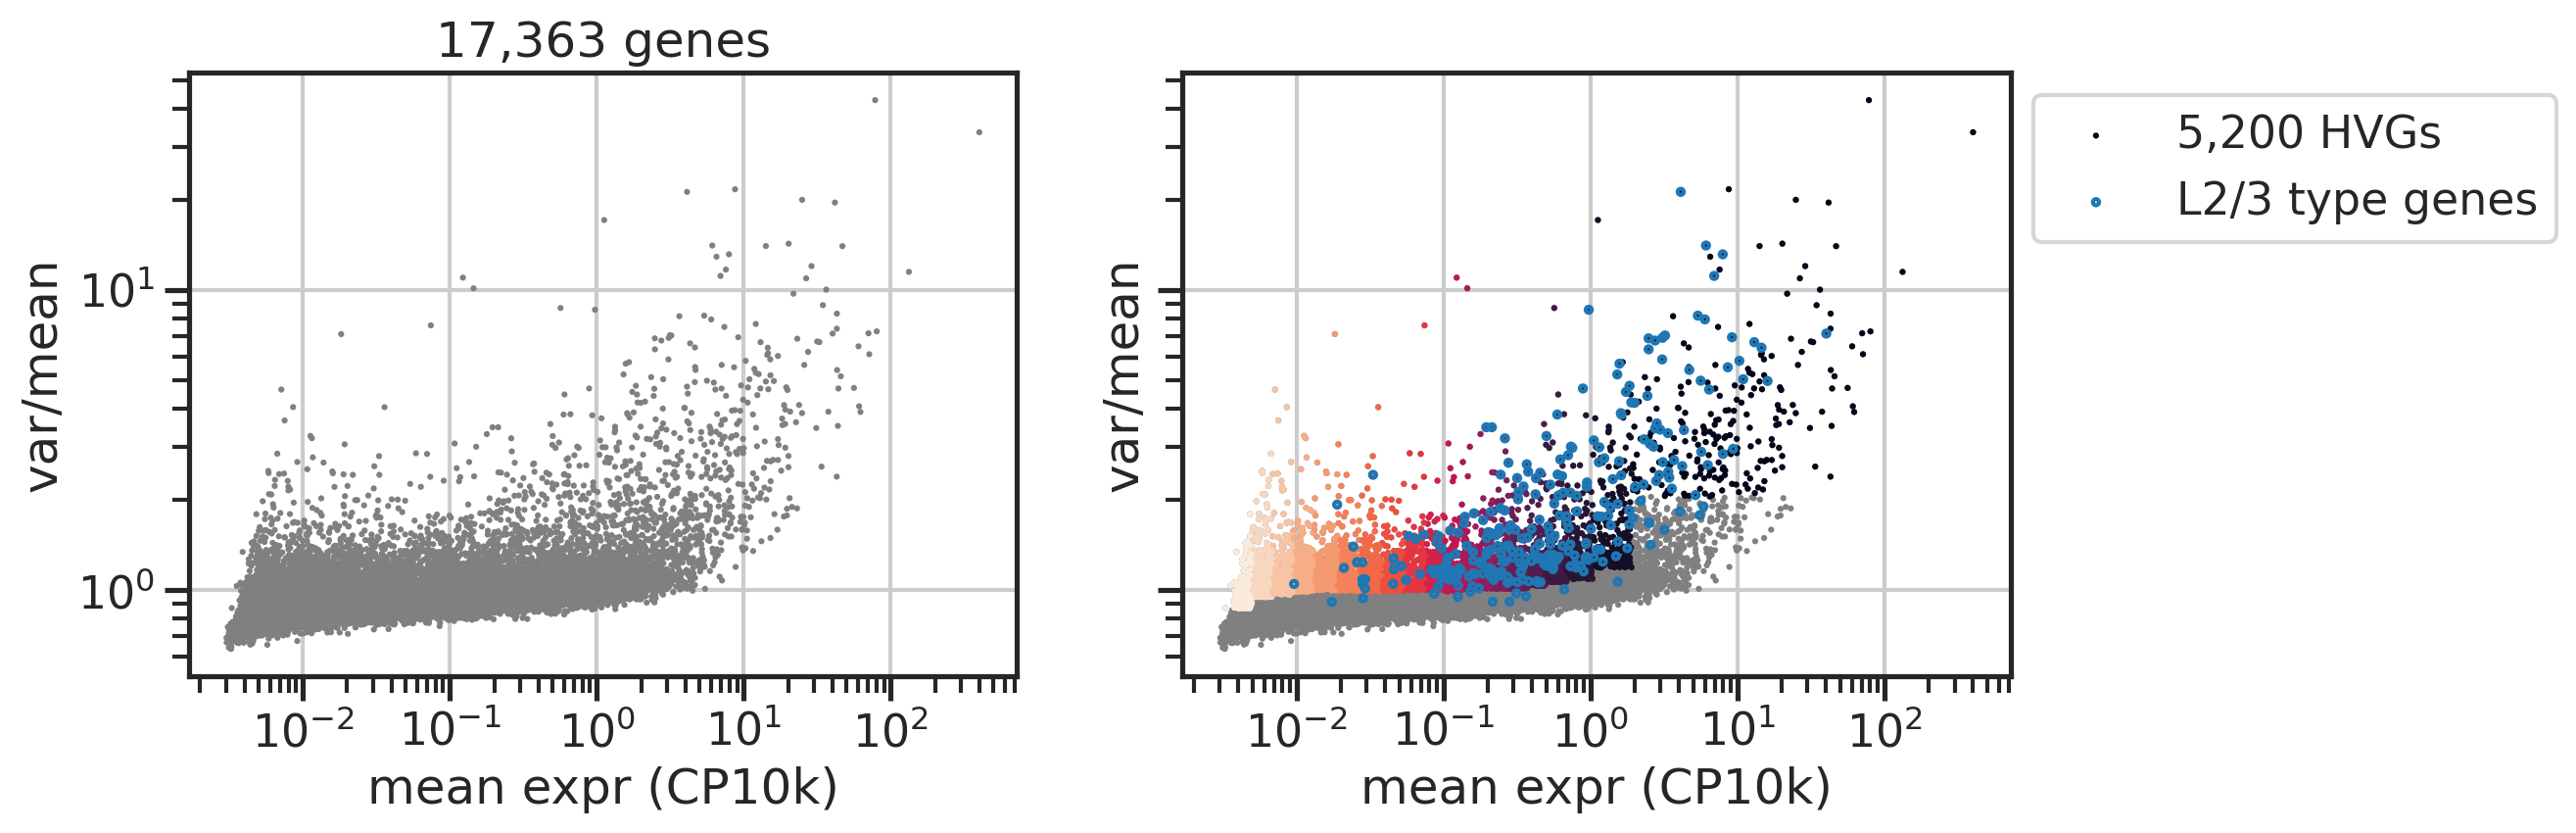

In [14]:
fig, axs = plt.subplots(1,2, figsize=(6*2,4), sharex=True, sharey=True)
ax = axs[0]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.set_title(f'{len(gm):,} genes')

ax = axs[1]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.scatter(gm[gsel_idx], (gv/gm)[gsel_idx], c=lbl[gsel_idx], s=5, edgecolor='none', cmap='rocket_r', label=f'{len(gsel_idx):,} HVGs')
ax.scatter(gm[l23_gidx], (gv/gm)[l23_gidx], s=5, facecolors='none', edgecolor='C0', label='L2/3 type genes')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.legend(bbox_to_anchor=(1,1))

plt.show()

In [15]:
adata = adata_sub[:,gsel_idx]
# adata = adata_sub[:,it_gidx]
genes_sel = adata.var.index.values
lognorm = np.array(adata.layers['lognorm'].todense())
zlognorm = zscore(lognorm, axis=0)
adata

View of AnnData object with n_obs × n_vars = 2285 × 5200
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
    layers: 'norm', 'lognorm'

In [16]:
%%time
np.random.seed(0)
pca = PCA(n_components=10)
pcs = pca.fit_transform(zlognorm)

CPU times: user 190 ms, sys: 25.9 ms, total: 215 ms
Wall time: 214 ms


In [17]:
# get results
res = pd.DataFrame(pcs, columns=np.char.add("PC", ((1+np.arange(pcs.shape[1])).astype(str))))
res['PC1'] = pcs[:,0]
res['PC2'] = -pcs[:,1]
res['cond'] = conds
res['type'] = types
res['newtype'] = newtypes
res['samp'] = samps
res['biosamp'] = res['samp'].apply(lambda x: x[:-1])
res

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,cond,type,newtype,samp,biosamp
0,-2.942791,-10.431964,-0.500560,9.780997,-4.859377,3.888219,-2.668802,0.671638,0.124859,-1.212439,P28NR,L6IT_B,L6IT_B,P28_1a,P28_1
1,-14.144231,0.247163,-7.628847,0.557041,6.807829,1.685081,-2.437001,-1.061537,-1.926388,1.834754,P28NR,L6IT_A,L6IT_A,P28_1a,P28_1
2,15.743704,6.764925,3.347451,2.127640,1.980922,2.701823,-6.823207,-1.325935,4.758284,3.418688,P28NR,L5IT,L5IT,P28_1a,P28_1
3,-1.011314,-17.030090,4.996287,8.800952,-1.900842,0.778163,3.387431,1.128528,-1.522461,1.131558,P28NR,L6IT_B,L6IT_B,P28_1a,P28_1
4,-11.658851,1.151842,-9.758521,6.146263,0.464349,2.495083,0.258342,-1.686354,1.040370,2.764839,P28NR,L6IT_A,L6IT_A,P28_1a,P28_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,-9.591197,4.460712,-1.493467,-0.805537,-3.806540,-3.787776,1.351455,-3.500549,0.147158,-0.938056,P28NR,L6IT_A,L6IT_A,P28_2b,P28_2
2281,-12.796831,-4.208862,14.170363,-13.371946,9.989490,-4.481861,2.545133,1.046032,2.956318,-1.804534,P28NR,L6IT_A,L6IT_A,P28_2b,P28_2
2282,-12.526342,5.613246,-4.825392,-3.197917,-3.160559,-1.943227,-0.668125,1.578355,1.625636,1.645993,P28NR,L6IT_A,L6IT_A,P28_2b,P28_2
2283,-9.232473,-0.727884,-3.250799,-5.209751,-6.119508,-2.774974,-2.968156,-0.365197,-0.196709,-2.127679,P28NR,L6IT_A,L6IT_A,P28_2b,P28_2


Text(0, 0.5, 'explained var')

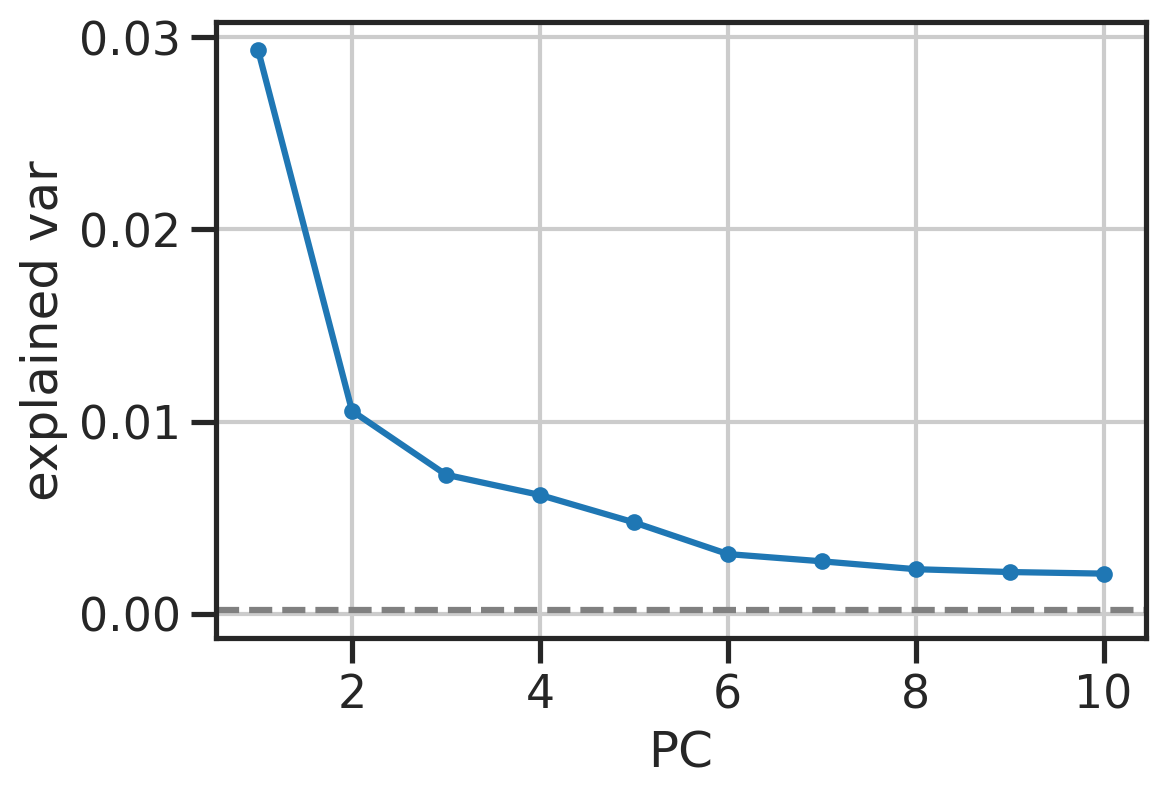

In [18]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_, '-o', markersize=5)
ax.axhline(1/lognorm.shape[1], linestyle='--', color='gray')
ax.set_xlabel('PC')
ax.set_ylabel('explained var')

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

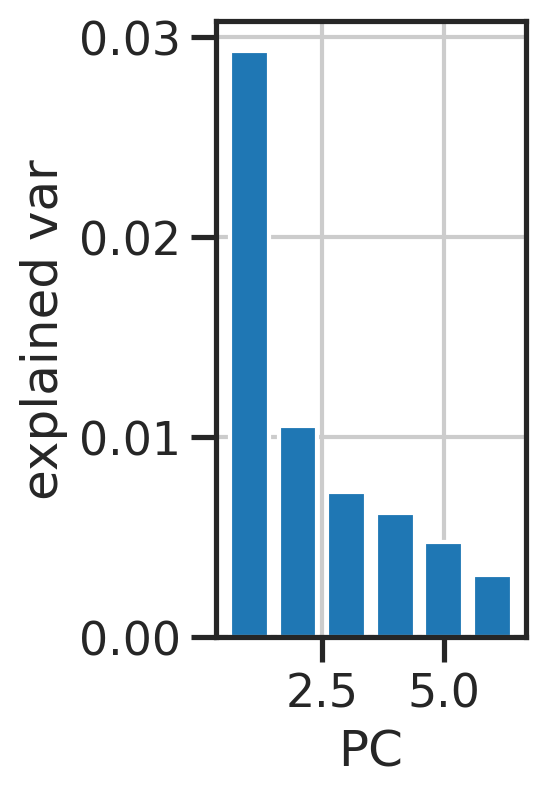

In [19]:
fig, ax = plt.subplots(figsize=(2,4))
ax.bar(np.arange(6)+1, pca.explained_variance_ratio_[:6],)
# ax.axhline(1/lognorm.shape[1], linestyle='--', color='gray')
ax.set_xlabel('PC')
ax.set_ylabel('explained var')
sns.despine

In [20]:
colors2 = sns.color_palette('tab10', 10)
colors2

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [30]:
colors = sns.color_palette('tab20', 10)
# 6-9
palette_biosamp = {
    'P28_1': colors[6],
    'P28_2': colors[7],
    'P28_dr_1': colors[8],
    'P28_dr_3': colors[9],
}
palette_cond = {
    'P28NR': 'C1', # colors[6],
    'P28DR': 'k', # colors[8],
}

palette_type_abc = {
    'L6IT_A': colors[0],
    'L6IT_B': colors[2],
    'L5IT': colors[4],
    
    # 'bg': 'lightgray',
}

In [22]:
def plot_pcs(res, npc, hue, palette=None):
    fig, axs = plt.subplots(npc-1,npc-1,figsize=(6*(npc-1),5*(npc-1)))
    for i, j in itertools.combinations(range(npc), 2):
        legend = False
        if (i,j) == (0,1): legend=True

        x, y = f"PC{j+1}", f"PC{i+1}"
        ax = axs[i,j-1]
        
        if palette is not None:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            hue_order=list(palette.keys()),
                            palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        else:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            # hue_order=list(palette.keys()),
                            # palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        sns.despine(ax=ax)
    axs[0,0].legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')

    for i, j in itertools.product(range(npc-1), range(npc-1)):
        if j<i:
            ax = axs[i,j]
            ax.axis('off')

    plt.show()

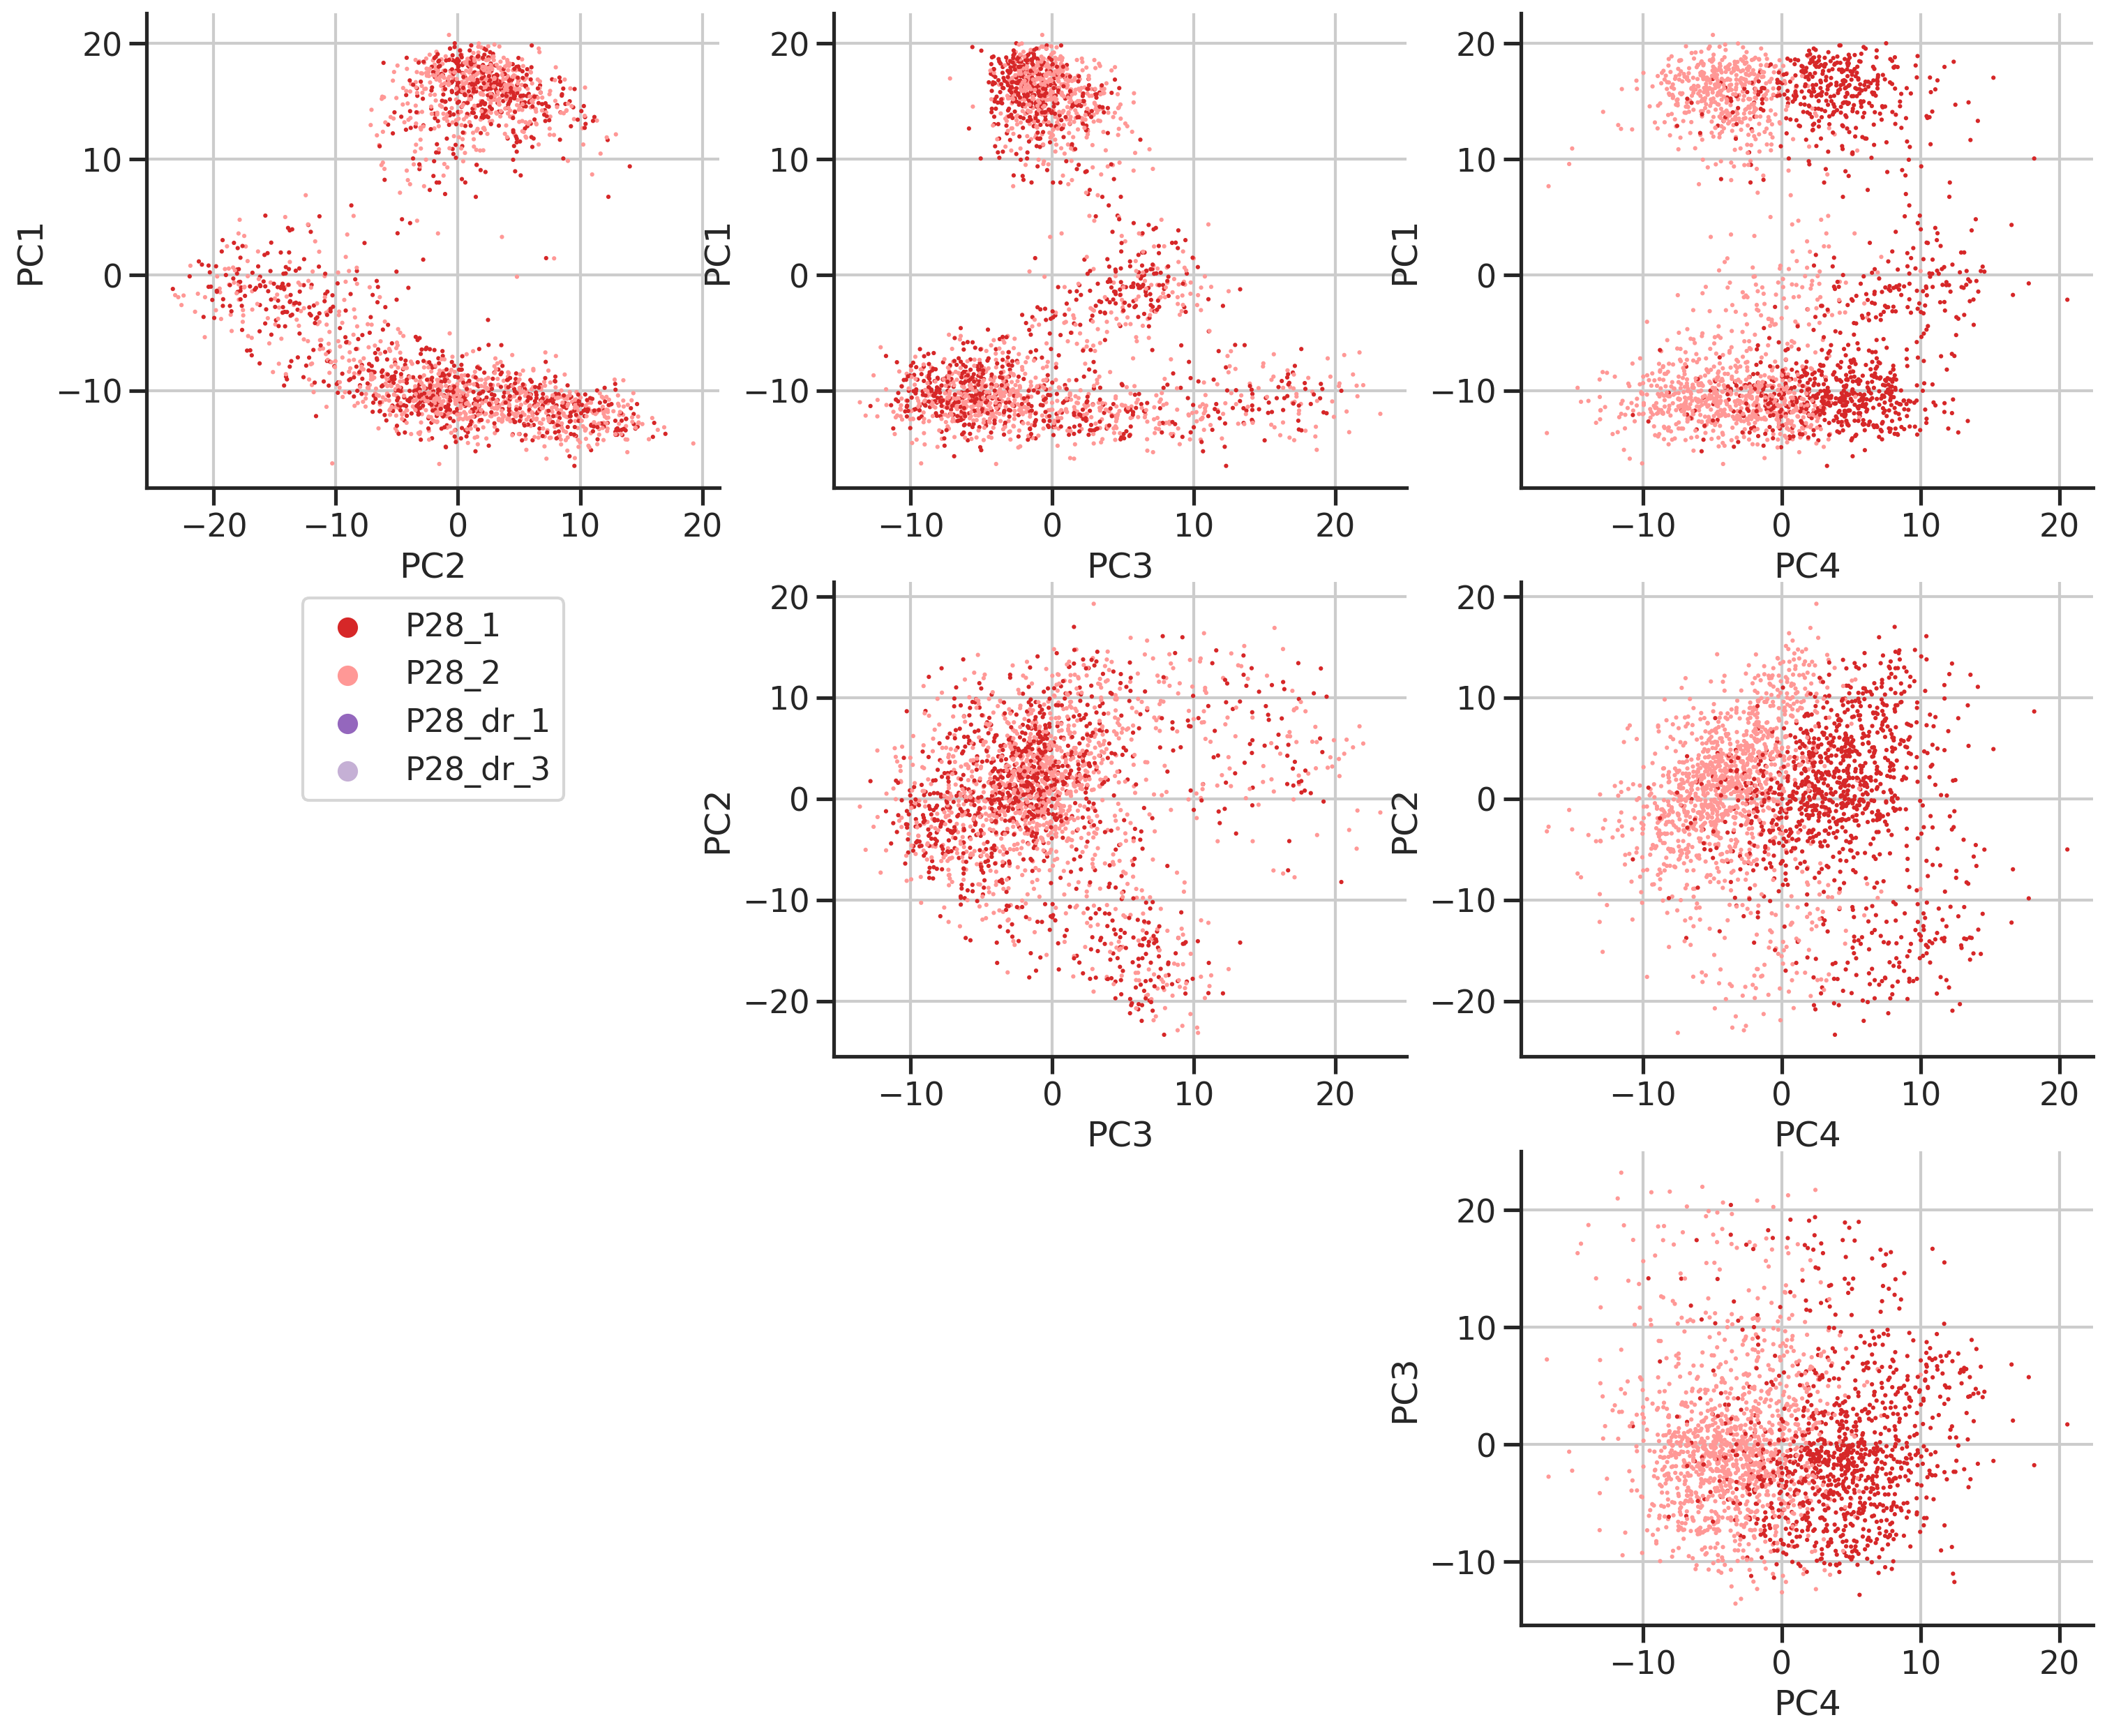

In [24]:
plot_pcs(res, 4, 'biosamp', palette=palette_biosamp)

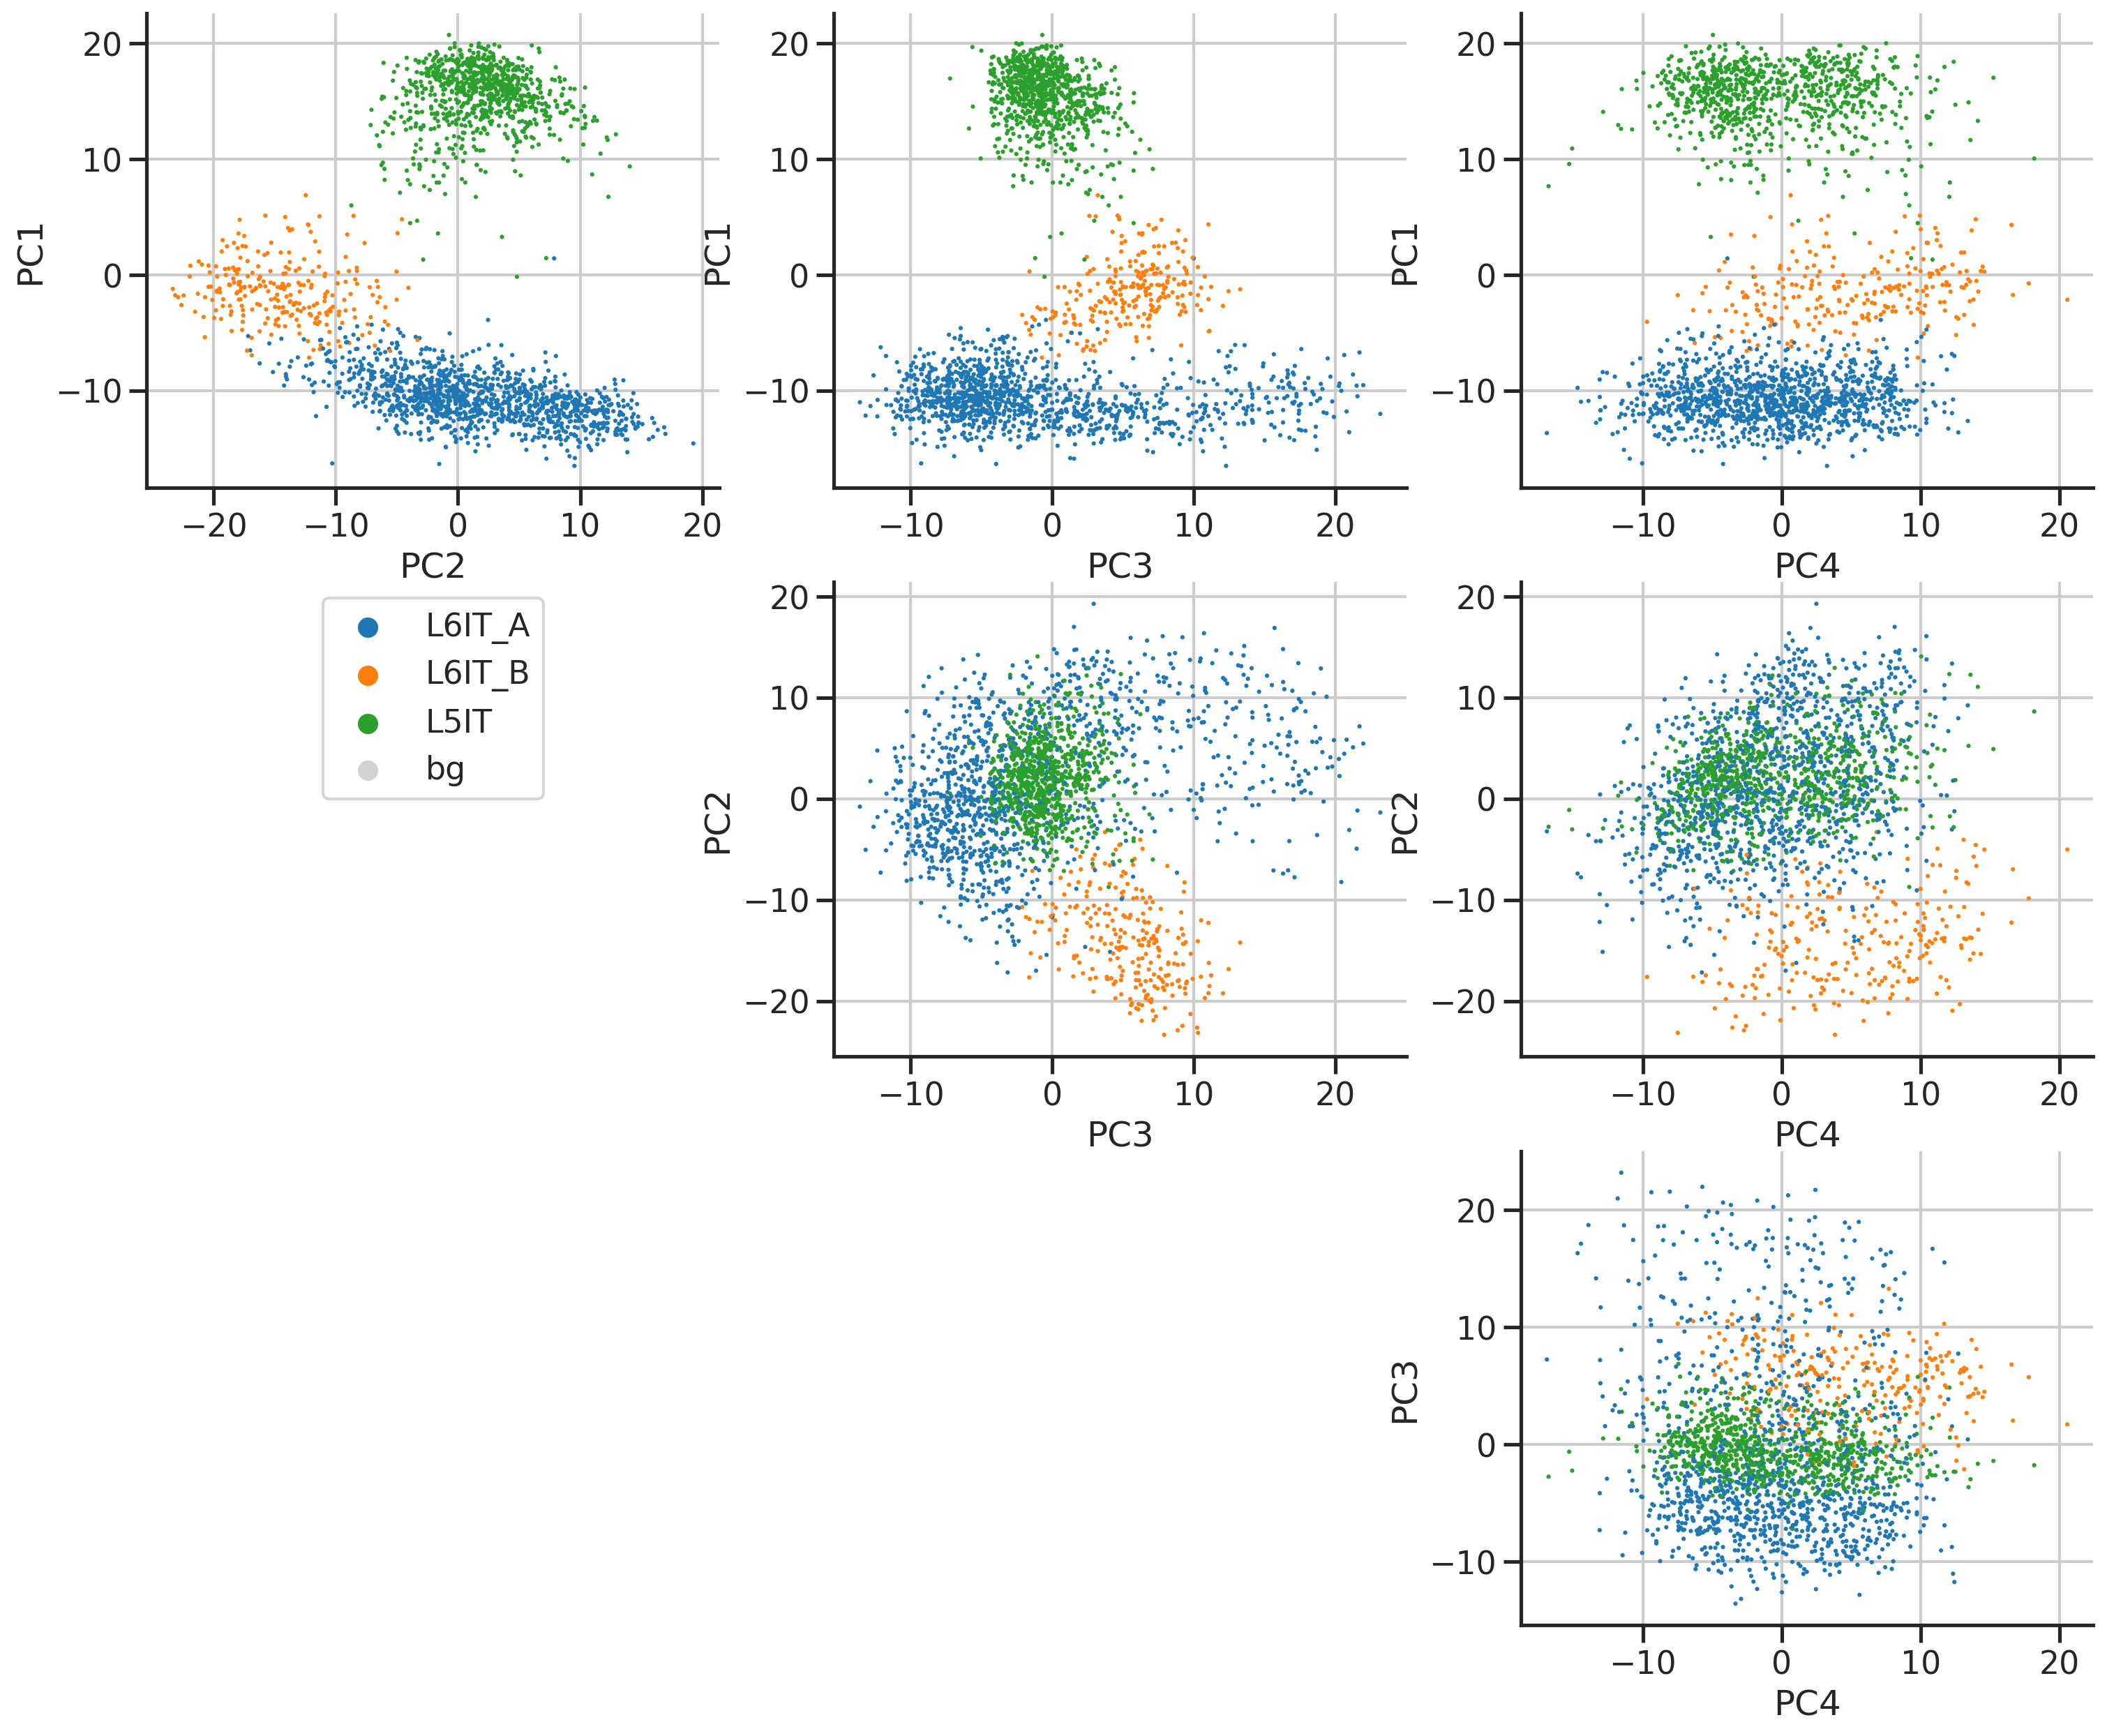

In [25]:
plot_pcs(res, 4, 'type', 
         palette=palette_type_abc,
        )

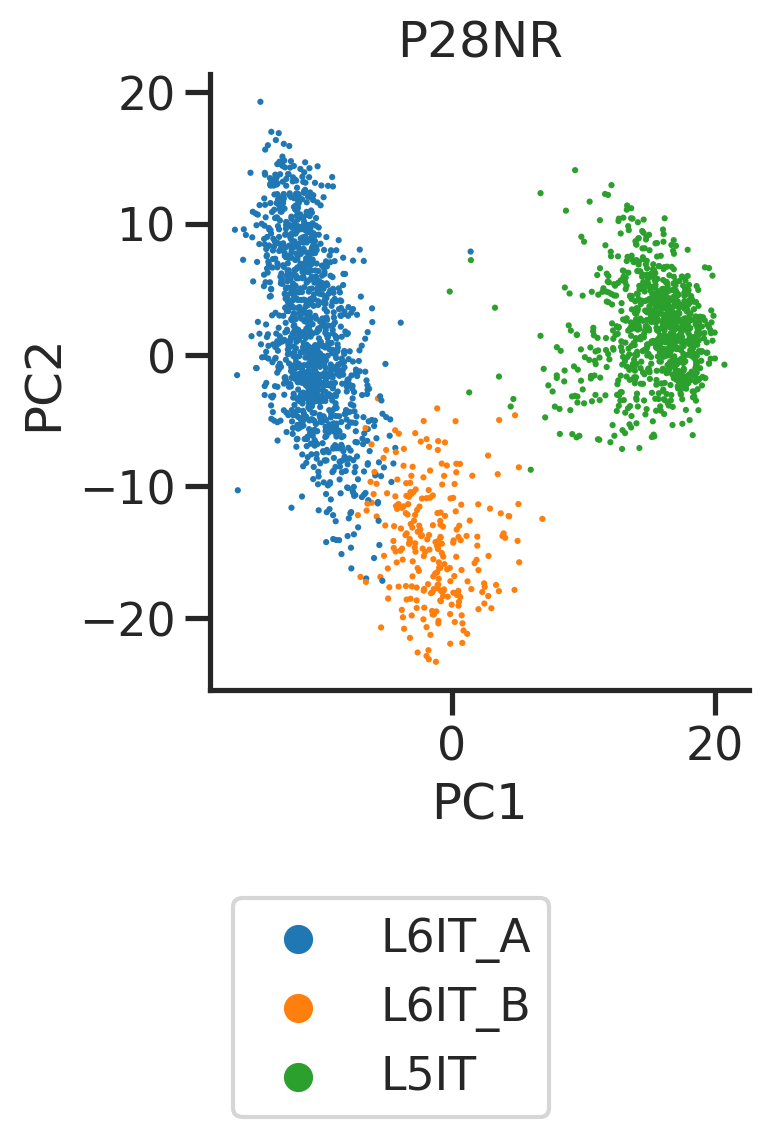

In [31]:
fig, ax = plt.subplots(1,1,figsize=(1*5, 1*4), sharex=True, sharey=True)
sns.scatterplot(data=res[res['cond']=='P28NR'], x='PC1', y='PC2', hue='type', s=5, 
                edgecolor='none', 
                palette=palette_type_abc, hue_order=list(palette_type_abc.keys()),
                ax=ax, rasterized=True)
ax.legend(bbox_to_anchor=(0, -0.3), loc='upper left')
sns.despine(ax=ax)
ax.set_aspect('equal')
ax.grid(False)
ax.set_title('P28NR')

# output = os.path.join(outfigdir, "figS1_nr_pc34.pdf")
# powerplots.savefig(fig, output)
plt.show()